# Transfer learning in Keras

https://keras.io/applications/

https://keras.io/callbacks/

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pathlib
import glob
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [5]:
print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data
Download pictures of Chess world champions from google and store them in a way that's compatible with imagenet.

On google images, search for the names of champions, then this on the Developer Console:

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

In [0]:
path = pathlib.Path('/content/gdrive/My Drive/data/champions')

In [0]:
classes = ['alekhine', 'botvinnik', 'casablanca', 'fischer', 'karpov', 'kasparov', 'kramnik', 'spassky']

In [0]:
folders = [path/c for c in classes]
files = [path/'urls_alekhine.csv', path/'urls_botvinnik.csv', path/'urls_casablanca.csv', path/'urls_fischer.csv', path/'urls_karpov.csv', path/'urls_kasparov.csv', path/'urls_kramnik.csv', path/'urls_spassky.csv']

In [0]:
# download the urls
for index in tqdm(range(len(files))):
    number = 0
    for url in open(files[index]).readlines():
        filename = folders[index]/('{0:04d}'.format(number)+'.jpg')
        try:
            urllib.request.urlretrieve(url, filename)
        except:
            pass
        number += 1


100%|██████████| 8/8 [31:15<00:00, 164.61s/it]


## Model
Load a ResNet-50 model with weigths pre-trained from the imagenet dataset, then use it a as backbone for the champions classifier model.

In [0]:
model1 = ResNet50(weights='imagenet')

### Transfer learning
Using transfer learning method to reuse the capabilities learnt by the image-net based model.
1. Remove the last layer of the original model as it was trained to classify images to one of 1000 imagenet classes (as it's use less in our case)
1. Add a header on top of this base model, 
2. Freeze the layers in this base model
3. Train only the head to learn how to classify the picture of the champions.

In [11]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
model1.layers[-3].output

<tf.Tensor 'activation_48/Relu:0' shape=(?, 7, 7, 2048) dtype=float32>

Helper functions to set the layers of a NN to trainable or not

In [0]:
# freeze all layers of the model (from left to right)
def freeze(model, limit=None):
    # handle negative indices
    if limit != None and limit < -1:
        limit = limit + len(model.layers) 
    # loop for all valid indices and mark the corresponding layer
    for index, layer in enumerate(model.layers):
        if limit != None and index > limit:
            break
        layer.trainable = False
        
# unfreeze all layers of the model up to the given layer index (from right to left)
def unfreeze(model, limit=None):
    # handle negative indices
    if limit != None and limit < -1:
        limit = limit + len(model.layers)
    for index, layer in enumerate(model.layers):
        if limit != None and index < limit:
            continue
        layer.trainable = True
        
        
def print_trainable_status(model):
    for layer in model.layers:
        output_shape = str(layer.output_shape)
        print('{:20} {:20} {}'.format(layer.name, output_shape, layer.trainable))

In [0]:
# use the layer before the average pool, which is before 1000 Dense one
# 1. freeze the original model up to the last layer we will keep
freeze(model1, -3)
#print_trainable_status(model1)
# 2. create a new model that will be chained to the output of our base model
x = model1.layers[-3].output          # shape should be (bs=None, 7, 7, 2048)
x = Dropout(rate=0.3)(x)              # shape should be (bs=None, 7, 7, 2048)
x = GlobalAveragePooling2D()(x)       # shape should be (bs=None, 2048)
x = Dense(1024, activation='relu')(x) # shape should be (bs=None, 1024)
x = BatchNormalization()(x)
predictions = Dense(len(classes), activation='softmax')(x) # shape should be (bs=None, num_champtions)

In [0]:
# create a new model with input similar to the base imagenet model and output as the predictions
model2 = Model(inputs=model1.input, outputs=predictions)

In [16]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Training

### Freeze base model
First: we need to train only the top layers (which were randomly initialized) and freeze all layers from the base model


In [0]:
for layer in model1.layers:
    layer.trainable = False

In [0]:
# compile the model to before training
adam = Adam(lr=0.001, epsilon=0.01, decay=0.0001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [173]:
model1.input.shape # inputs to the Resnet-50 are tensors are images of 224x224

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

### Generate training data

We need to generates batches of samples indefinitely, our features is an array of data with shape (batch_size,224,224,3) and labels is an array of data with shape (batch_size,1). We use data from features and labels to train our model.

In [0]:
# use this generator: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

"""
https://github.com/keras-team/keras/issues/2702
model.fit_generator( ..., 
                    validation_data=val_datagen.flow(val_X, val_y, batch_size=BATCH_SIZE), 
                    nb_val_samples=val_X.shape[0])
"""
def generator(path, classes, batch_size, size=(224, 224), validation=False): 
    """generates batches of samples indefinitely
    parameters:
       sample_per_epoch: number of samples you want to train in each epoch
       nb_epoch: number of epochs
       batch_size: number of the samples in a batch
       validation: whether to generate train or validation set
    """
    images,labels = [], []
    for index in range(len(classes)):
        pattern = folders[index].as_posix()
        if not validation:
            pattern += '/train/*.jpg'
        else:
            pattern += '/valid/*.jpg'
        # append each file in this folder to the output
        for img_path in glob.glob(pattern):
            img = image.load_img(img_path, target_size=size)
            img_data = image.img_to_array(img)
            lbl_data = np.zeros((8), dtype=np.float32); lbl_data[1]=1
            images.append(img_data)
            labels.append(lbl_data)
            if len(images) == batch_size:
                features, targets = np.array(images), np.array(labels)
                images,labels = [], []
                yield features, targets
        if len(images) > 0:
            features, targets = np.array(images), np.array(labels)
            images,labels = [], []
            yield features, targets

In [0]:
class ImageGenerator(Sequence):
    """Generator for a sequence of Images"""
    def __init__(self, path, classes, batch_size, image_size=(224, 224), validation=False, shuffle=True):
        self.validation = validation
        self.image_size, self.batch_size = image_size, batch_size
        self.urls, self.labels = self.get_urls_(path, classes)
        self.items_size = len(self.urls)
        self.classes_size = len(classes)
        self.indexes = np.arange(self.items_size)
        self.shuffle= shuffle
        self.on_epoch_end()
        
    def get_urls_(self, path, classes):
        """Load the path for every item"""
        urls,labels = [], []
        for i, c in enumerate(classes):
            pattern = (path/c).as_posix()
            if not self.validation:
                pattern += '/train/*.jpg'
            else:
                pattern += '/valid/*.jpg'
            # add all elements in those folders
            for img_path in glob.glob(pattern):
                urls.append(img_path)
                labels.append(i)
        return urls, labels

    def load_urls_(self, indexes):
        """Load the urls of the images into a tensor"""
        # init target arrays
        images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        labels = np.zeros((self.batch_size, self.classes_size), dtype=np.float32)
        # Find list of urls in this batch
        urls = [self.urls[k] for k in indexes]
        lbls = [self.labels[k] for k in indexes]
        for index, img_path in enumerate(urls):
            # read image from url
            img = preprocessing.image.load_img(img_path, target_size=self.image_size)
            img_data = preprocessing.image.img_to_array(img)
            # read the proper label
            lbl_data = np.zeros((8), dtype=np.float32)
            lbl_data[lbls[index]]=1
            # append data
            images[index, :] = img_data
            labels[index, :] = lbl_data
            
        return images, labels
        
    def on_epoch_end(self):
        """Rearrange the indexes after each epoch"""
        self.indexes = np.arange(self.items_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(self.items_size / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data for the batch
        X, y = self.load_urls_(indexes)
        return X, y

In [0]:
# setup generators for train and validation set
train_dl = ImageGenerator(path, classes, batch_size=48)
valid_dl = ImageGenerator(path, classes, batch_size=48, validation=True)

In [176]:
len(train_dl), len(valid_dl)

(25, 3)

In [0]:
class DataBunch:
    def __init__(self, train_dl, valid_dl, test_dl=None):
        self.train_dl, self.valid_dl, self.test_dl = train_dl, valid_dl, test_dl
        
    def one_item(self):
        batch_index = np.random.randint(low=0, high=len(self.train_dl)-1, size=1)[0]
        X, y = self.train_dl[batch_index]
        item_index = np.random.randint(low=0, high=len(X)-1, size=1)[0]
        item = X[item_index]
        img = Image.fromarray(item, mode='RGBA')
        return img
    
    def show_batch(self, rows=2, **kwargs):
        """e.g. show_batch(rows=3, figsize=(7,6))"""
        batch = np.random.choice(self.train_dl)
        for nrows in rows:
            ncols = rows
            for index in rows:
                plt.subplot(nrows, ncols, index, **kwargs)
                data = np.random.choice(batch)
                img = Image.fromarray(data, mode='RGBA')
                plt.imshow(img)
                #fig, axs = plt.subplots(1,2,figsize=(12,4))

In [0]:
#PIL.imshow 
data = DataBunch(train_dl, valid_dl)
#data.show_batch()

(48, 224, 224, 3)
(224, 224, 3)


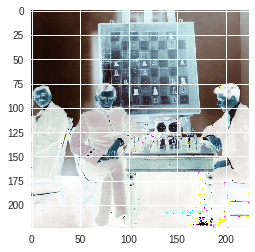

In [196]:
batch_index = np.random.randint(low=0, high=len(train_dl)-1, size=1)[0]
batch, y = train_dl[batch_index]; print(batch.shape)
item_index = np.random.randint(low=0, high=len(batch)-1, size=1)[0]
item = batch[item_index]; print(item.shape)
plt.imshow(item)

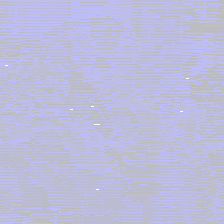

In [236]:
img = data.one_item()
img

In [182]:
train_dl[1][0].shape

(48, 224, 224, 3)

In [183]:
# fit the model using the previous generators
history = model2.fit_generator(generator=train_dl, validation_data=valid_dl, epochs=10, use_multiprocessing=True)

Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 2.3700 - acc: 0.2225 - val_loss: 2.1767 - val_acc: 0.2083
Epoch 2/10
25/25 [==============================] - 23s 928ms/step - loss: 1.2931 - acc: 0.5425 - val_loss: 1.9670 - val_acc: 0.3125
Epoch 3/10
25/25 [==============================] - 24s 941ms/step - loss: 0.8134 - acc: 0.7342 - val_loss: 2.0662 - val_acc: 0.2708
Epoch 4/10
25/25 [==============================] - 23s 931ms/step - loss: 0.5553 - acc: 0.8500 - val_loss: 1.9618 - val_acc: 0.3056
Epoch 5/10
25/25 [==============================] - 23s 927ms/step - loss: 0.3806 - acc: 0.9100 - val_loss: 1.9709 - val_acc: 0.3472
Epoch 6/10
25/25 [==============================] - 23s 923ms/step - loss: 0.2981 - acc: 0.9417 - val_loss: 1.9505 - val_acc: 0.3958
Epoch 7/10
25/25 [==============================] - 23s 925ms/step - loss: 0.2262 - acc: 0.9592 - val_loss: 2.0578 - val_acc: 0.3819
Epoch 8/10
25/25 [==============================] - 23s 916ms/step - los

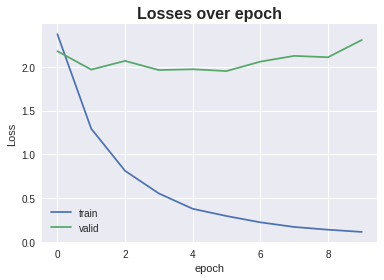

In [184]:
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Losses over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.show()

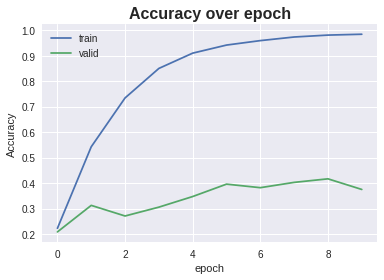

In [185]:
plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Accuracy over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Accuracy")

plt.show()

## Prediction

In [0]:
class ImageItem():
    def __init__(self, x):
        self.image_size = image_size

    
    def from_url(img_path, image_size=(224, 224)):
        img = preprocessing.image.load_img(img_path, target_size=image_size)
        img_data = preprocessing.image.img_to_array(img)
        x = np.expand_dims(img_data, axis=0)
        x = preprocess_input(x)
        return img, img_data, x

In [221]:
img_path = folders[0]/'train'/'0000.jpg'
glob.glob(folders[0].as_posix()+'/*.jpg')
img, img_data, x = ImageItem.from_url(img_path)
img_data.shape, x.shape

((224, 224, 3), (1, 224, 224, 3))

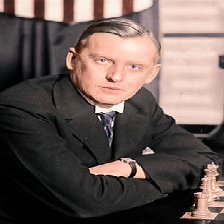

In [222]:
#plt.imshow(img)
#plt.imshow(img_data)
img

In [230]:
output = model2.predict(x)
class_index = np.argmax(output[0])
print('Prediction: {}'.format(classes[class_index]))

Prediction: alekhine


In [229]:
# read image
img_path = folders[1]/'valid'/'0294.jpg'
glob.glob(folders[1].as_posix()+'/*.jpg')
img, img_data, x = ImageItem.from_url(img_path)
# run prediction
output = model2.predict(x)
class_index = np.argmax(output[0])
print('Prediction: {}'.format(classes[class_index]))
print(output)

Prediction: alekhine
[[0.59878016 0.03679577 0.05551967 0.15379982 0.10860271 0.01326552
  0.0139983  0.01923813]]


In [206]:
classes

['alekhine',
 'botvinnik',
 'casablanca',
 'fischer',
 'karpov',
 'kasparov',
 'kramnik',
 'spassky']

### Confusion Matrix

In [0]:
test_dl = ImageGenerator(path, classes, batch_size=48, validation=True)

In [252]:
y = []
y_hat = []
iterations = len(test_dl)
print('Number of iterations: {}'.format(iterations))
for i in range(iterations):
    X_batch, y_batch = test_dl[i]
    y_hat_batch = model2.predict(X_batch)
    for j in range(len(y_batch)):
        y.append(np.argmax(y_batch[j]))
        y_hat.append(np.argmax(y_hat_batch[j]))

Number of iterations: 3


In [0]:
def display_confusion_matrix(cm, labels):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

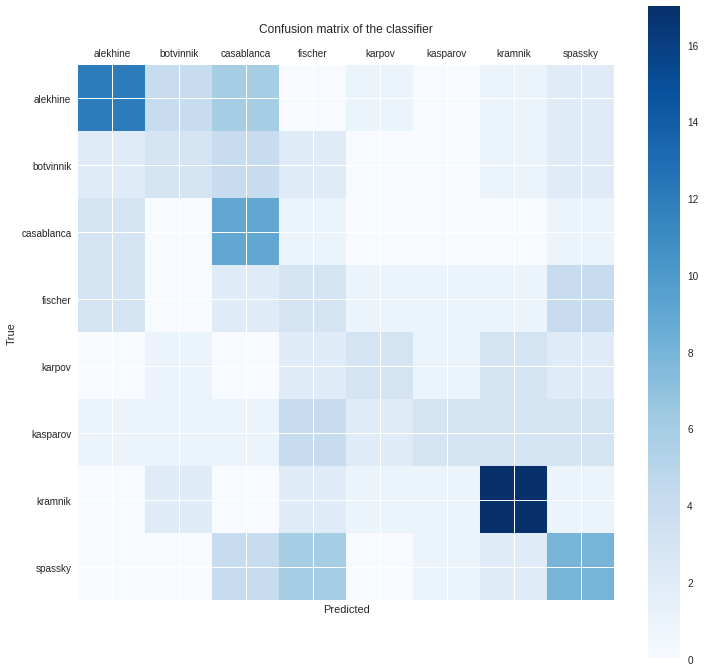

In [270]:
y_label = [classes[i] for i in y]
y_hat_label = [classes[i] for i in y_hat]

cm = confusion_matrix(y_label, y_hat_label, classes); #print(cm)
#display_confusion_matrix(y, y_hat, classes)
display_confusion_matrix(cm, classes)

### Activation

#### Heatmap

In [314]:
img_path = folders[0]/'train'/'0000.jpg'
glob.glob(folders[0].as_posix()+'/*.jpg')
img, img_data, x = ImageItem.from_url(img_path)
img_data.shape, x.shape

((224, 224, 3), (1, 224, 224, 3))

In [289]:
output = model1.layers[-3](x); output.shape

TensorShape([Dimension(1), Dimension(224), Dimension(224), Dimension(3)])

In [293]:
model1.layers[-3].output_shape

(None, 7, 7, 2048)

In [309]:
x1 = model2.layers[0](x)
x1.shape

(1, 224, 224, 3)

In [320]:
target_layer_index = len(model2.layers) - 6 # activation_48
model2.layers[target_layer_index].name

'activation_48'

calculate the output of the activation layer

In [325]:
target_layer_output = K.function([model2.layers[0].input], [model2.layers[target_layer_index].output])
activations = target_layer_output([x])[0]
activations.shape

(1, 7, 7, 2048)

average on the last dimension then scale the 7x7 matrix to image_size then display it on top of the original image

In [337]:
activations_avg = activations.mean(-1)[0]; activations_avg.shape

(7, 7)

In [0]:
def show_heatmap(img, hm):
    _,ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0), interpolation='bilinear', cmap='magma');

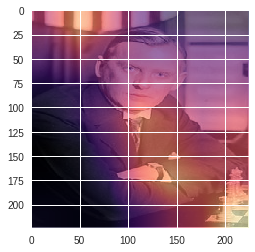

In [342]:
show_heatmap(img, activations_avg)